In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (11.9, 10)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect, TimedInput
from connectivity_functions import create_orthogonal_canonical_representation, build_network_representation
from connectivity_functions import get_weights_from_probabilities, get_probabilities_from_network_representation
from connectivity_functions import create_matrix_from_sequences_representation, produce_overlaped_sequences
from analysis_functions import calculate_recall_time_quantities, get_weights
from analysis_functions import get_weights_collections
from plotting_functions import plot_network_activity_angle, plot_weight_matrix
from analysis_functions import calculate_angle_from_history, calculate_winning_pattern_from_distances
from analysis_functions import calculate_patterns_timings, calculate_recall_success_nr, calculate_T_persistence

epsilon = 10e-80

In [2]:
def mean_at_t(t, w_self, w_next, g_a, tau_m, tau_a, s0, perfect=False, steady_state=False):
    r = tau_m / tau_a
    A  = 1.0 / (1 - r)
    if perfect:
        mean_diff = w_self - g_a * (1 - np.exp(-t / tau_a))
    else:
        mean_diff = w_self - g_a * (1 - np.exp(-t / tau_a) * A)
        if steady_state:
            mean_diff += 0.0
        else:
            mean_diff += (s0 - w_self - g_a * r * A) * np.exp(-t / tau_m)
        
    return mean_diff

## Sampling

In [3]:
sigma = 2.0
num = 100000
w1 = 2.0
w2 = 1.0
w3 = 0.0
s1 = np.random.normal(loc=w1, scale=sigma, size=num)
s2 = np.random.normal(loc=w2, scale=sigma, size=num)
s3 = np.random.normal(loc=w3, scale=sigma, size=num)
x  = s1 - s3
y = s2 - s1
x_mean = w1 - w3
y_mean = w2 - w1

In [4]:
print('std', np.std(y), np.sqrt(2) * sigma, 'mean', np.mean(x), w1 - w3, np.mean(y), w2 - w1)

std 2.82116334276 2.82842712475 mean 2.0035684982 2.0 -0.989488007193 -1.0


In [5]:
mvndst

NameError: name 'mvndst' is not defined

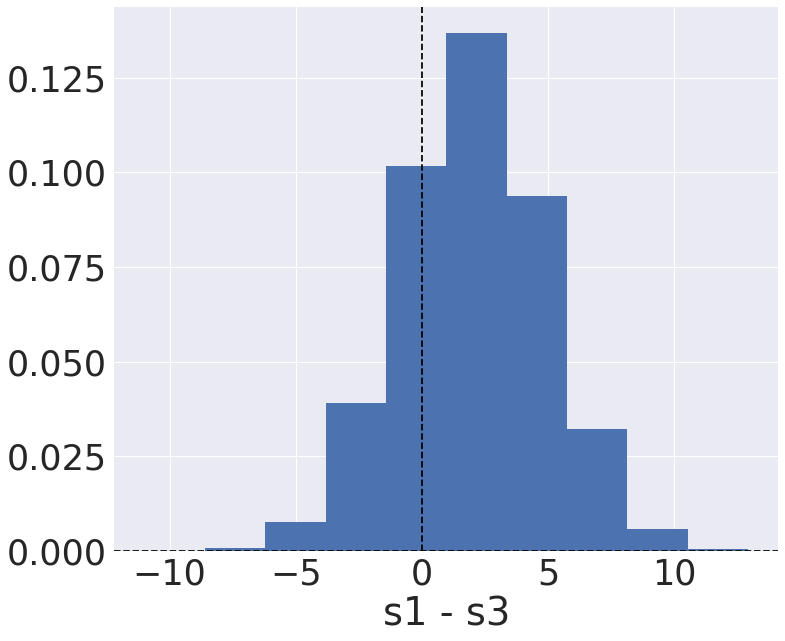

In [6]:
plt.hist(x, normed=True)
plt.xlabel('s1 - s3')

plt.axhline(0, ls='--', color='black')
plt.axvline(0, ls='--', color='black')

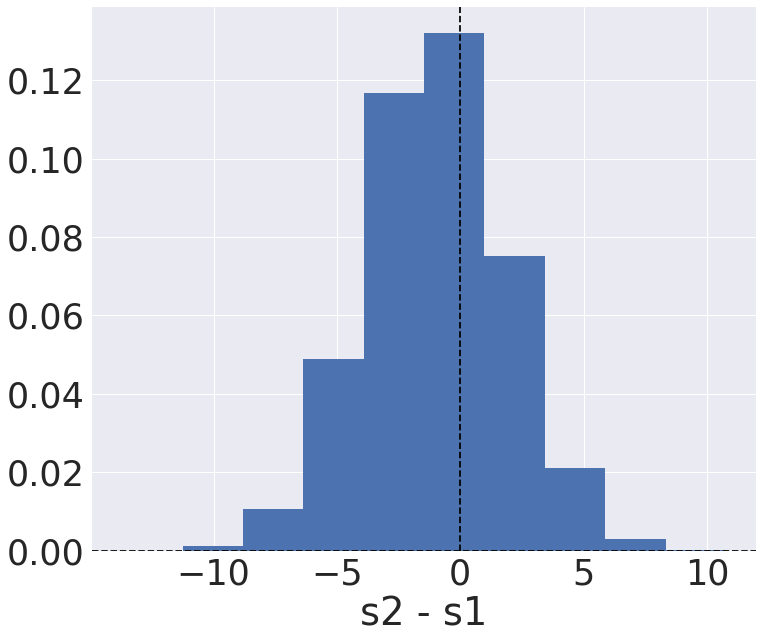

In [7]:
plt.hist(y ,normed=True)

plt.xlabel('s2 - s1')
plt.axhline(0, ls='--', color='black')
plt.axvline(0, ls='--', color='black')

In [8]:
np.cov(x, y)

array([[ 7.96646, -3.97228],
       [-3.97228,  7.95904]])

In [9]:
print('e_xy should be =', np.mean(x * y))

e_xy should be = -5.9547452221


In [10]:
print('cov should be = ', np.mean(x * y) - x_mean * y_mean)

cov should be =  -3.9547452221


In [11]:
A = (x + y)
B = (x - y)
A_mean = np.mean(A)
B_mean = np.mean(B)
e_xy_estimated_1 = 0.25 * (np.var(A) + A_mean **2 - np.var(B)  - B_mean**2)
print('A mean', A_mean)
print('B mean', B_mean)
print('e_xy estimated', e_xy_estimated_1)
print('e_xy should be', np.mean(x * y))


A mean 1.014080491
B mean 2.99305650539
e_xy estimated -5.9547452221
e_xy should be -5.9547452221


This are equal, let's see wehther we can approximate A with a chi-square and what is its mean

In [12]:
print(np.mean(A**2))
A2_mean = np.var(A) + (np.mean(x) + np.mean(y)) **2
print(A2_mean)
aux = np.var(A) + (w2 - w3)**2
print(aux)
e_theo = 2 * sigma ** 2 + (w2 - w3)**2
print(e_theo)

9.00922373863
9.00922373863
8.9808644964
9.0


In [13]:
print(np.mean(B**2))
B2_mean = np.var(B) + (np.mean(x) - np.mean(y)) **2
print(B2_mean)
aux = np.var(B) + (w1 - w3 + w1 - w2)**2
print(aux)
e_theo = 6 * sigma ** 2 + (w1 - w3 + w1 - w2)**2
print(e_theo)

32.828204627
32.828204627
32.8698173826
33.0


In [14]:
e_xy = 0.25 * ((w2 - w3)**2  - (w1 - w3 + w1 - w2)**2 - 4 * sigma ** 2)
print(e_xy)
print(np.mean(x * y))

-6.0
-5.9547452221


In [15]:
e_xy = 0.25 * ((w2 - w3)**2  - (w1 - w3 + w1 - w2)**2 - 4 * sigma ** 2)
a = e_xy  - (w1 - w3) * (w2 - w1)
cov = np.array(((2*sigma**2, a), (a, 2*sigma**2)))
mean = ((x_mean, y_mean))

In [16]:
pprint.pprint(cov)
pprint.pprint(np.cov(x, y))

array([[ 8., -4.],
       [-4.,  8.]])
array([[ 7.96646, -3.97228],
       [-3.97228,  7.95904]])


In [17]:
normal = sp.stats.multivariate_normal(mean=mean, cov=cov)

In [18]:
a = normal.rvs(size=num)

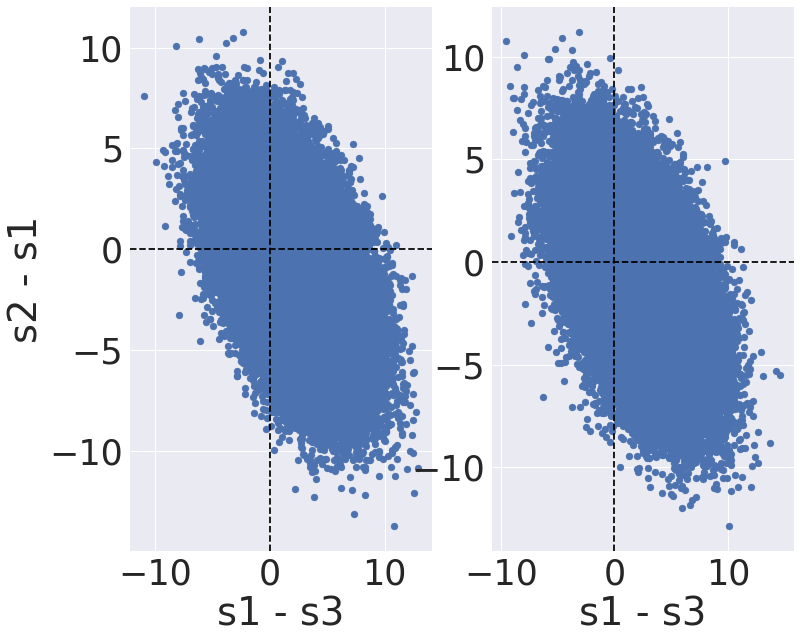

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(x, y)
ax2.scatter(a[:, 0], a[:, 1])

ax1.set_xlabel('s1 - s3')
ax1.set_ylabel('s2 - s1')

ax1.axhline(0, ls='--', color='black')
ax1.axvline(0, ls='--', color='black')

ax2.set_xlabel('s1 - s3')

ax2.axhline(0, ls='--', color='black')
ax2.axvline(0, ls='--', color='black')

Let's wrap this in a function, the mean of w1 will be subsittued by the tau function evolviong

## Expectation of the product of two random variables

In [24]:
num = 10000
x_mean = 10.0
sigma  = 2.0
y_mean = 5.0

x = np.random.normal(loc=x_mean, scale=sigma, size=num)
y = np.random.normal(loc=y_mean, scale=sigma, size=num)
z = x * y 
z_mean = np.mean(x * y)

(array([ 0.00161,  0.     ,  0.00161,  0.00323,  0.00968,  0.00645,
         0.02098,  0.02904,  0.05002,  0.08068,  0.10488,  0.18072,
         0.19686,  0.27108,  0.3211 ,  0.3808 ,  0.55507,  0.5712 ,
         0.7132 ,  0.77613,  0.87778,  0.89553,  0.98589,  0.9746 ,
         1.04237,  0.93749,  0.90683,  0.87456,  0.85519,  0.68093,
         0.57927,  0.51957,  0.40017,  0.38242,  0.25172,  0.20654,
         0.1662 ,  0.10488,  0.08229,  0.03711,  0.0355 ,  0.02259,
         0.02259,  0.00968,  0.00161,  0.00161,  0.00323,  0.00161,
         0.     ,  0.00161]),
 array([ 0.50838,  0.57035,  0.63232,  0.6943 ,  0.75627,  0.81825,
         0.88022,  0.9422 ,  1.00417,  1.06614,  1.12812,  1.19009,
         1.25207,  1.31404,  1.37602,  1.43799,  1.49996,  1.56194,
         1.62391,  1.68589,  1.74786,  1.80984,  1.87181,  1.93378,
         1.99576,  2.05773,  2.11971,  2.18168,  2.24366,  2.30563,
         2.3676 ,  2.42958,  2.49155,  2.55353,  2.6155 ,  2.67748,
         2.73945, 

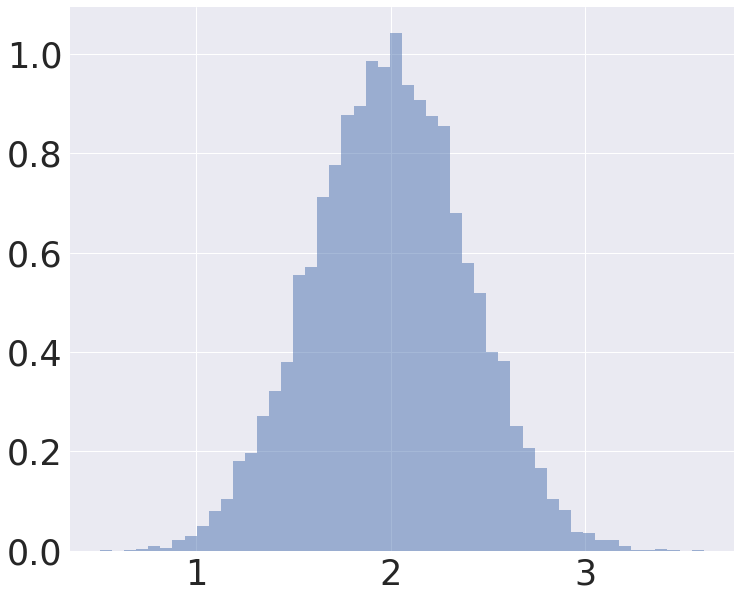

In [25]:
plt.hist(x/5, normed=True, alpha=0.5, bins=50) ;
# plt.hist(y, normed=True, alpha=0.5, bins=50);
#plt.hist(x * y, normed=True, alpha=0.5, bins=50);

In [26]:
z_estimated = 0.25 * ((x + y)**2 - (x - y)**2) 
np.sum(z_estimated - z)

3.7931203317187467e-13

In [27]:
estimated_exy = np.var(x + y)  + (x_mean + y_mean)**2  - np.var(x - y) - (x_mean- y_mean)**2 
estimated_exy = estimated_exy * 0.25


In [28]:
estimated_exy

49.968880352803545

In [29]:
z_mean

49.976459405040806

## CDF of a multivariate

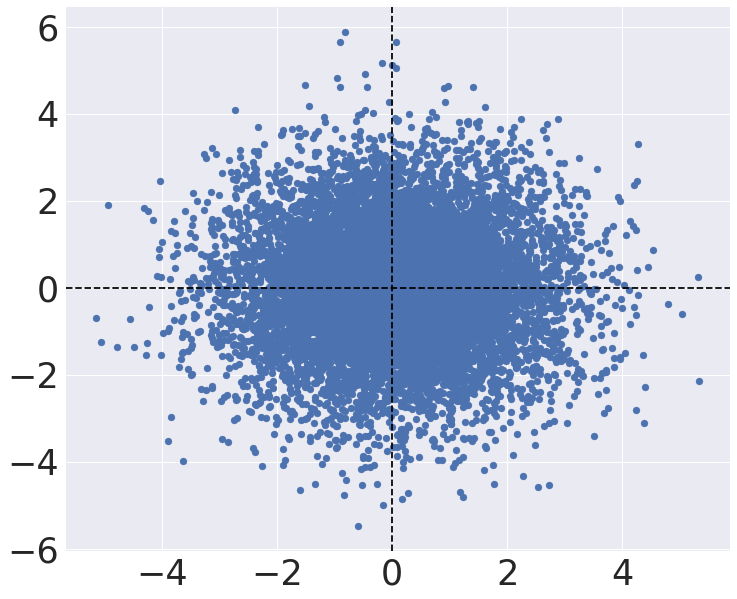

In [30]:
from statsmodels.sandbox.distributions.extras import mvnormcdf

cov_example = np.array(((2, 0), (0, 2)))
mean_example = np.array((0, 0))
normal_example = sp.stats.multivariate_normal(mean=mean_example, cov=cov_example)
x = normal_example.rvs(size=10000)
plt.scatter(x[:, 0], x[:, 1]);
plt.axhline(0, ls='--', color='black')
plt.axvline(0, ls='--', color='black');

## Test the covariances

In [121]:
sigma = 2.0
num = 100000
w1 = 2.0
w2 = 1.0
w3 = 0.0
s1 = np.random.normal(loc=w1, scale=sigma, size=num)
s2 = np.random.normal(loc=w2, scale=sigma, size=num)
s3 = np.random.normal(loc=w3, scale=sigma, size=num)

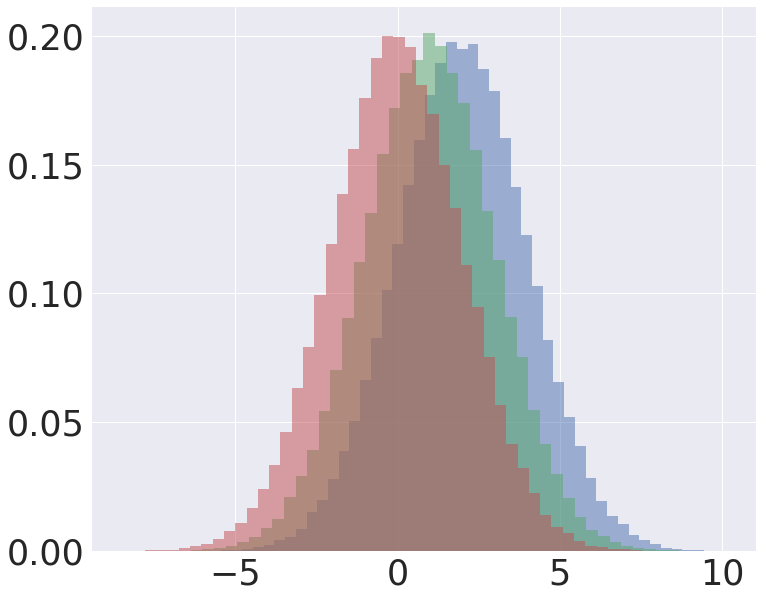

In [122]:
plt.hist(s1, normed=True, alpha=0.5, bins=50) ;
plt.hist(s2, normed=True, alpha=0.5, bins=50);
plt.hist(s3, normed=True, alpha=0.5, bins=50);

#### Stay succesfully at t

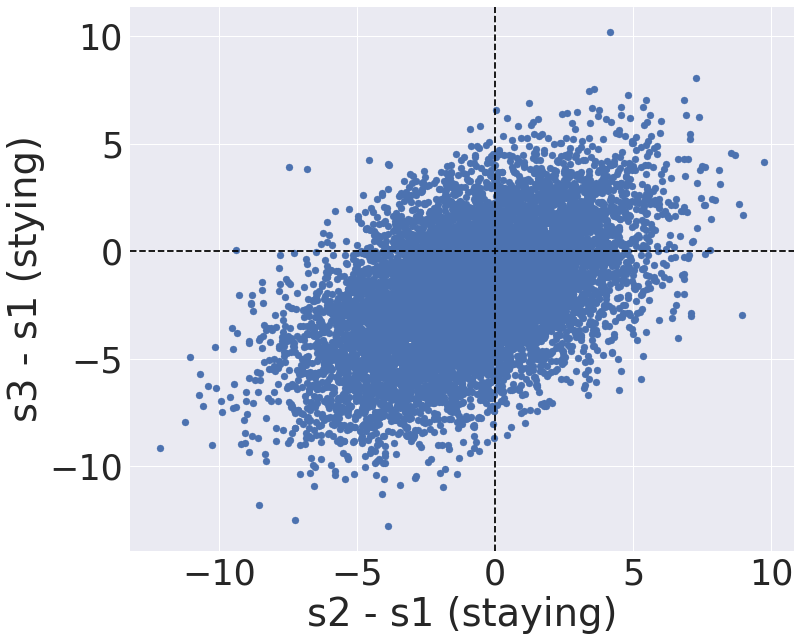

In [135]:
x = s2 - s1  # < 0 staying because you did not transtiion correctly
y = s3 - s1  # < 0 staying because you did not transition incorrecly
Ex = w2 - w1
Ey = w3 - w1 
# Get the expectation of the moments with the Xi2 technique
Axy = 6 * sigma**2 
Bxy = 2 * sigma**2 
Exy = 0.25 * (Axy - Bxy) 
cov_xy = sigma**2
var_xx = 2 * sigma ** 2
var_yy = 2 * sigma ** 2
mean = np.array((Ex, Ey))
cov = np.array(((var_xx, cov_xy), (cov_xy, var_yy)))

normal = sp.stats.multivariate_normal(mean=mean, cov=cov)
examples = normal.rvs(size=10000)
plt.scatter(examples[:, 0], examples[:, 1])

plt.xlabel('s2 - s1 (staying against success)')
plt.ylabel('s3 - s1 (satying against failure)')
plt.axhline(0, ls='--', color='black')
plt.axvline(0, ls='--', color='black');

In [129]:
pprint.pprint(cov)
pprint.pprint(np.cov(examples, rowvar=False))
pprint.pprint(np.cov(x, y))

array([[ 8.,  4.],
       [ 4.,  8.]])
array([[ 8.14724,  4.10584],
       [ 4.10584,  8.04789]])
array([[ 8.03091,  3.98011],
       [ 3.98011,  7.96969]])


#### Covariance of failing

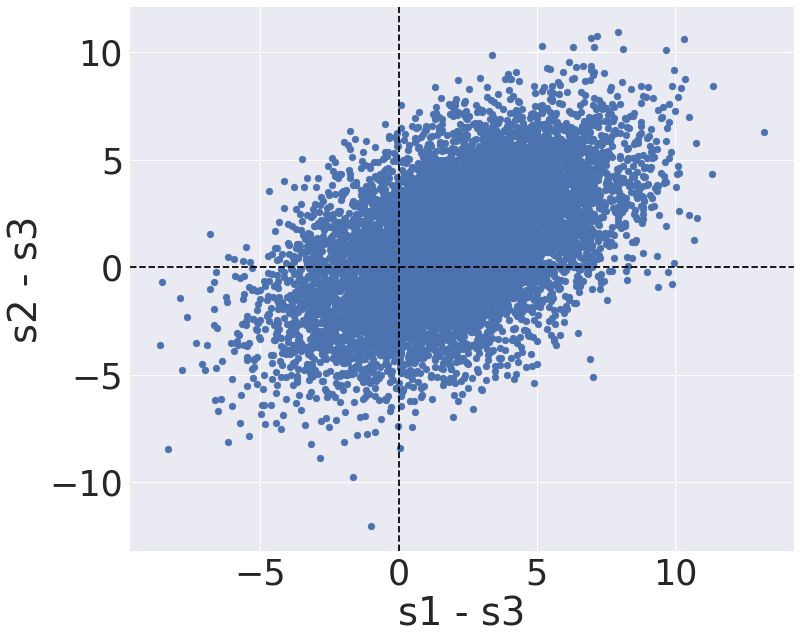

In [150]:
x = s1 - s3  # <0 Jumping wrong
y = s2 - s3   # <0 Not jumping right

Ex = w1 - w3
Ey = w2 - w3

cov_xy = sigma ** 2
cov_yx = cov_xy
var_xx = 2 * sigma ** 2
var_yy = 2 * sigma ** 2


mean = np.array((Ex, Ey))
cov = np.array(((var_xx, cov_xy), (cov_yx, var_yy)))

normal = sp.stats.multivariate_normal(mean=mean, cov=cov)
examples = normal.rvs(size=10000)
plt.scatter(examples[:, 0], examples[:, 1])

plt.xlabel('s1 - s3')
plt.ylabel('s2 - s3')
plt.axhline(0, ls='--', color='black')
plt.axvline(0, ls='--', color='black');

#### Jump to the right state

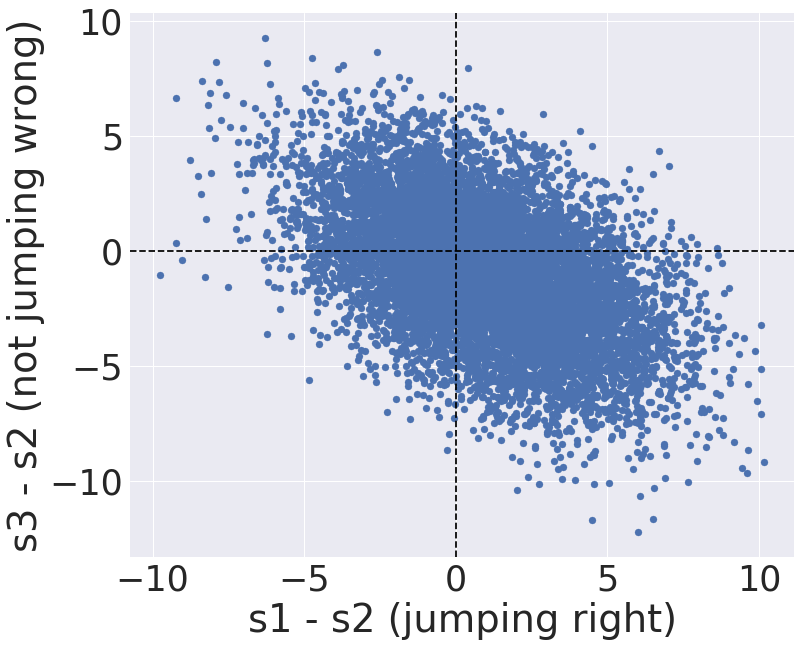

In [151]:
x = s1 - s2   # <0 jumping to the right state
y = s3 - s2  # <0 not jumping to the incorrect one

Ex = w1 - w2   # 
Ey = w3 - w2 

cov_xy = -sigma ** 2
cov_yx = cov_xy

var_xx = 2 * sigma ** 2
var_yy = 2 * sigma ** 2

mean = np.array((Ex, Ey))
cov = np.array(((var_xx, cov_xy), (cov_yx, var_yy)))

normal = sp.stats.multivariate_normal(mean=mean, cov=cov)
examples = normal.rvs(size=10000)
plt.scatter(examples[:, 0], examples[:, 1])

plt.xlabel('s1 - s2 (jumping right)')
plt.ylabel('s3 - s2 (not jumping wrong)')
plt.axhline(0, ls='--', color='black')
plt.axvline(0, ls='--', color='black');

In [152]:
pprint.pprint(cov)
pprint.pprint(np.cov(examples, rowvar=False))
pprint.pprint(np.cov(x, y))

array([[ 8., -4.],
       [-4.,  8.]])
array([[ 8.03508, -4.01992],
       [-4.01992,  7.99034]])
array([[ 8.02891,  4.00888],
       [ 4.00888,  7.97915]])


## Define the probabilities with the joint probabilities and the cdf of the mvn

In [166]:
def stay_at_t(w1, w2, w3, sigma):
    Ex = w2 - w1
    Ey = w3 - w1 
    cov_xy = sigma ** 2
    var_xx = 2 * sigma ** 2
    var_yy = 2 * sigma ** 2
    mean = np.array((Ex, Ey))
    cov = np.array(((var_xx, cov_xy), (cov_xy, var_yy)))
    
    upper = np.zeros(2)
    p_stay = mvnormcdf(upper=upper, mu=mean, cov=cov)
    
    return p_stay

def fail_at_t(w1, w2, w3, sigma):
    Ex = w1 - w3
    Ey = w2 - w3

    cov_xy = sigma ** 2
    cov_yx = cov_xy
    var_xx = 2 * sigma ** 2
    var_yy = 2 * sigma ** 2


    mean = np.array((Ex, Ey))
    cov = np.array(((var_xx, cov_xy), (cov_yx, var_yy)))

    upper = np.zeros(2)  
    p_fail = mvnormcdf(upper=upper, mu=mean, cov=cov)
    return p_fail

def transtition_at_t(w1, w2, w3, sigma):
    Ex = w1 - w2   # 
    Ey = w3 - w2 

    cov_xy = sigma ** 2
    cov_yx = cov_xy

    var_xx = 2 * sigma ** 2
    var_yy = 2 * sigma ** 2

    mean = np.array((Ex, Ey))
    cov = np.array(((var_xx, cov_xy), (cov_yx, var_yy)))
    upper = np.zeros(2)
    
    p_transition = mvnormcdf(upper=upper, mu=mean, cov=cov)
    return p_transition

In [167]:
sigma = 2.0
num = 100000
w1 = 2.0
w2 = 1.0
w3 = 0.0
s1 = np.random.normal(loc=w1, scale=sigma, size=num)
s2 = np.random.normal(loc=w2, scale=sigma, size=num)
s3 = np.random.normal(loc=w3, scale=sigma, size=num)

p1 = stay_at_t(w1, w2, w3, sigma)
p2 = fail_at_t(w1, w2, w3, sigma)
p3 = transtition_at_t(w1, w2, w3, sigma)

In [168]:
total = p1 + p2 + p3
print('stay', p1, 'fail', p2, 'trans', p3)
print('total', total)

stay 0.5487437165504273 fail 0.15033058255978568 trans 0.300925700889787
total 1.0


#### Sanity checks
1) If w1 is far away from w2 and w3 you should always stay.

CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 64 ms


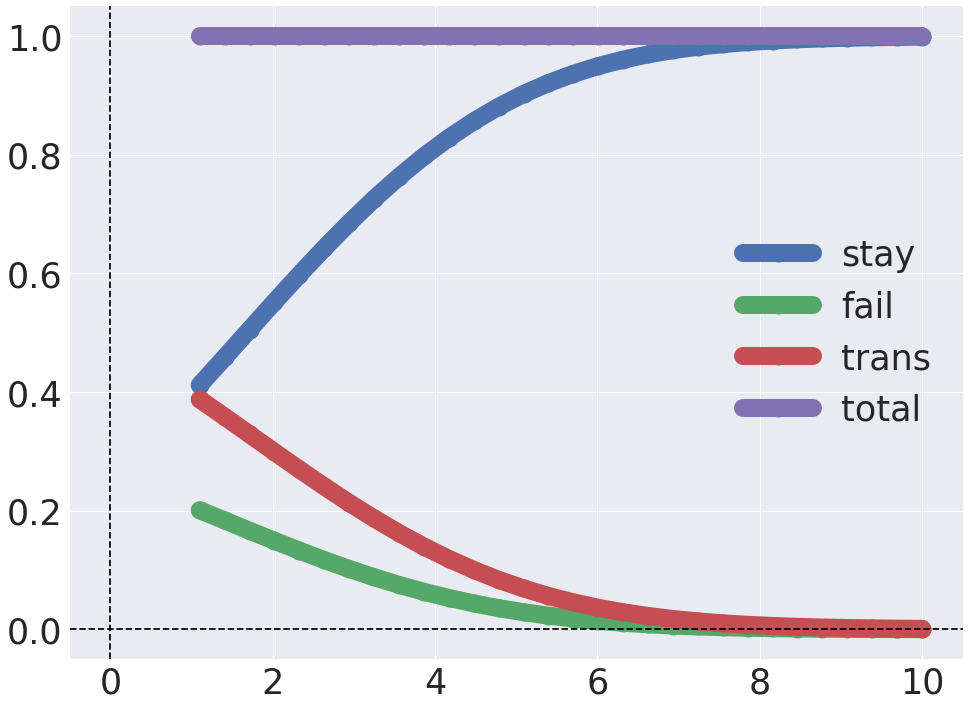

In [189]:
%%time
sigma = 2.0
w1 = 2.0
w2 = 1.0
w3 = 0.0

num = 30
w1_vector = np.linspace(1.1, 10, num=num)
p1_vector = np.zeros(num)
p2_vector = np.zeros(num)
p3_vector = np.zeros(num)

for index, w1, in enumerate(w1_vector):

    p1_vector[index] = stay_at_t(w1, w2, w3, sigma)
    p2_vector[index] = fail_at_t(w1, w2, w3, sigma)
    p3_vector[index] = transtition_at_t(w1, w2, w3, sigma)

lw = 18
ms = 18
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(w1_vector, p1_vector, 'o-', lw=lw, ms=ms, label='stay')
ax.plot(w1_vector, p2_vector, 'o-', lw=lw, ms=ms, label='fail')
ax.plot(w1_vector, p3_vector, 'o-', lw=lw, ms=ms, label='trans')
ax.plot(w1_vector, p1_vector + p2_vector + p3_vector, 'o-', lw=lw, ms=ms, label='total')


ax.axhline(0, ls='--', color='black')
ax.axvline(0, ls='--', color='black');
ax.legend();

If w3 is really far away from the other too and w1=w2 you should either transittion or stay most of the time

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 61.7 ms


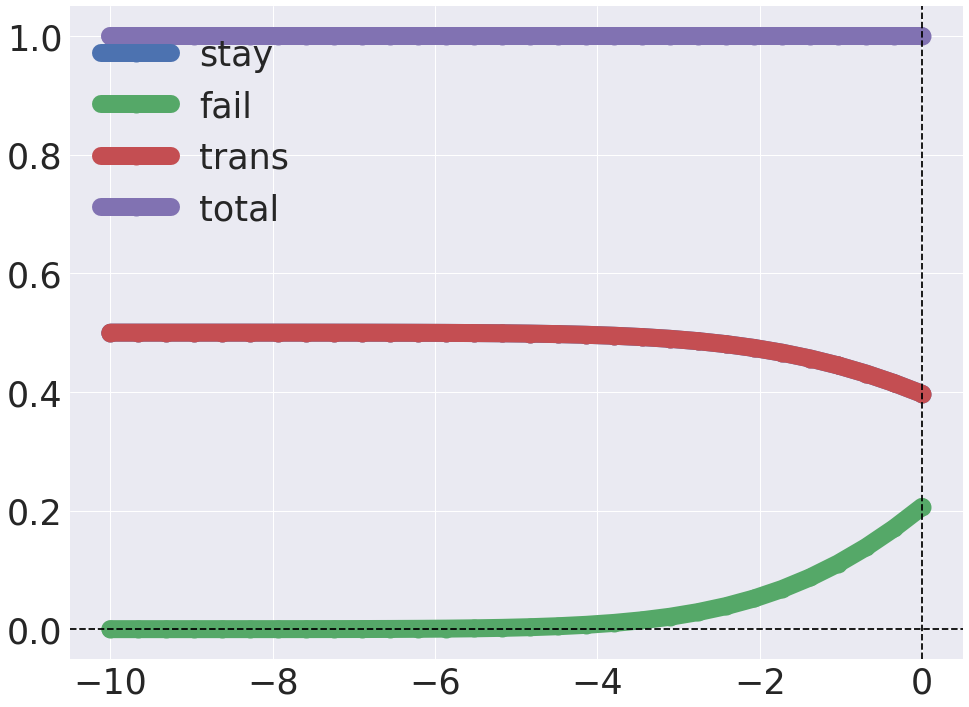

In [171]:
%%time
sigma = 2.0
w1 = 1.0
w2 = 1.0
w3 = 0.0

num = 30
w3_vector = np.linspace(0, -10, num=num)
p1_vector = np.zeros(num)
p2_vector = np.zeros(num)
p3_vector = np.zeros(num)

for index, w3, in enumerate(w3_vector):

    p1_vector[index] = stay_at_t(w1, w2, w3, sigma)
    p2_vector[index] = fail_at_t(w1, w2, w3, sigma)
    p3_vector[index] = transtition_at_t(w1, w2, w3, sigma)

lw = 18
ms = 18
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(w3_vector, p1_vector, 'o-', lw=lw, ms=ms, label='stay')
ax.plot(w3_vector, p2_vector, 'o-', lw=lw, ms=ms, label='fail')
ax.plot(w3_vector, p3_vector, 'o-', lw=lw, ms=ms, label='trans')
ax.plot(w3_vector, p1_vector + p2_vector + p3_vector, 'o-', lw=lw, ms=ms, label='total')


ax.axhline(0, ls='--', color='black')
ax.axvline(0, ls='--', color='black');
ax.legend();

This should becomes less well separated with noise

CPU times: user 64 ms, sys: 4 ms, total: 68 ms
Wall time: 63.5 ms


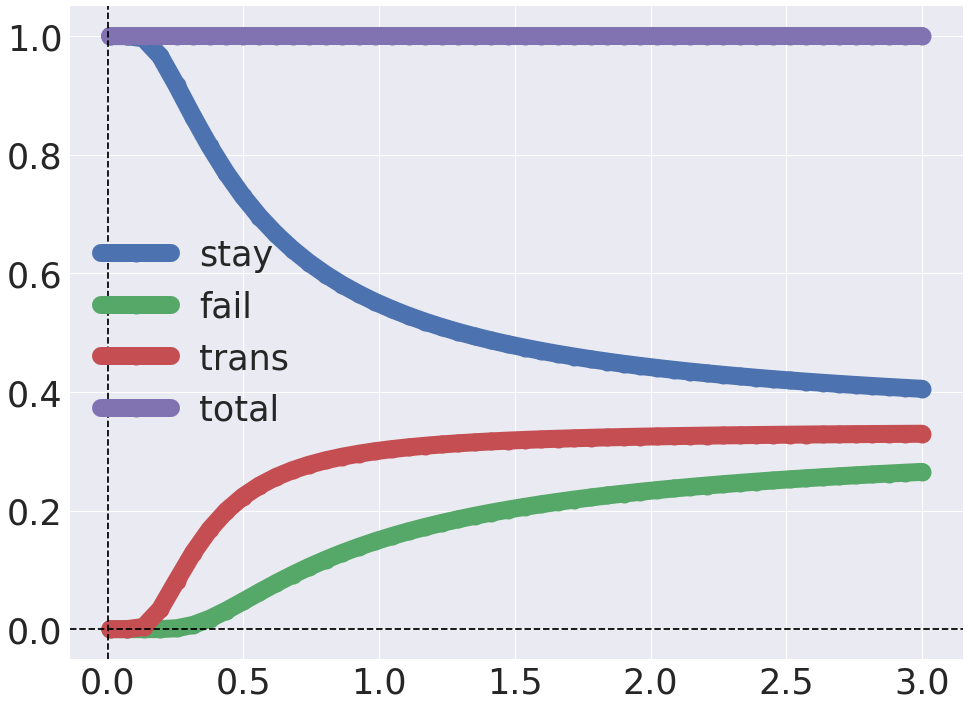

In [172]:
%%time
sigma = 2.0
w1 = 1.0
w2 = 0.5
w3 = 0.0

num = 50
sigma_vector = np.linspace(0.01, 3.0, num=num)
p1_vector = np.zeros(num)
p2_vector = np.zeros(num)
p3_vector = np.zeros(num)

for index, sigma, in enumerate(sigma_vector):

    p1_vector[index] = stay_at_t(w1, w2, w3, sigma)
    p2_vector[index] = fail_at_t(w1, w2, w3, sigma)
    p3_vector[index] = transtition_at_t(w1, w2, w3, sigma)

lw = 18
ms = 18
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(sigma_vector, p1_vector, 'o-', lw=lw, ms=ms, label='stay')
ax.plot(sigma_vector, p2_vector, 'o-', lw=lw, ms=ms, label='fail')
ax.plot(sigma_vector, p3_vector, 'o-', lw=lw, ms=ms, label='trans')
ax.plot(sigma_vector, p1_vector + p2_vector + p3_vector, 'o-', lw=lw, ms=ms, label='total')


ax.axhline(0, ls='--', color='black')
ax.axvline(0, ls='--', color='black');
ax.legend();

More relevant how close w1 and w2 need to be for the system to fail

CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 60.1 ms


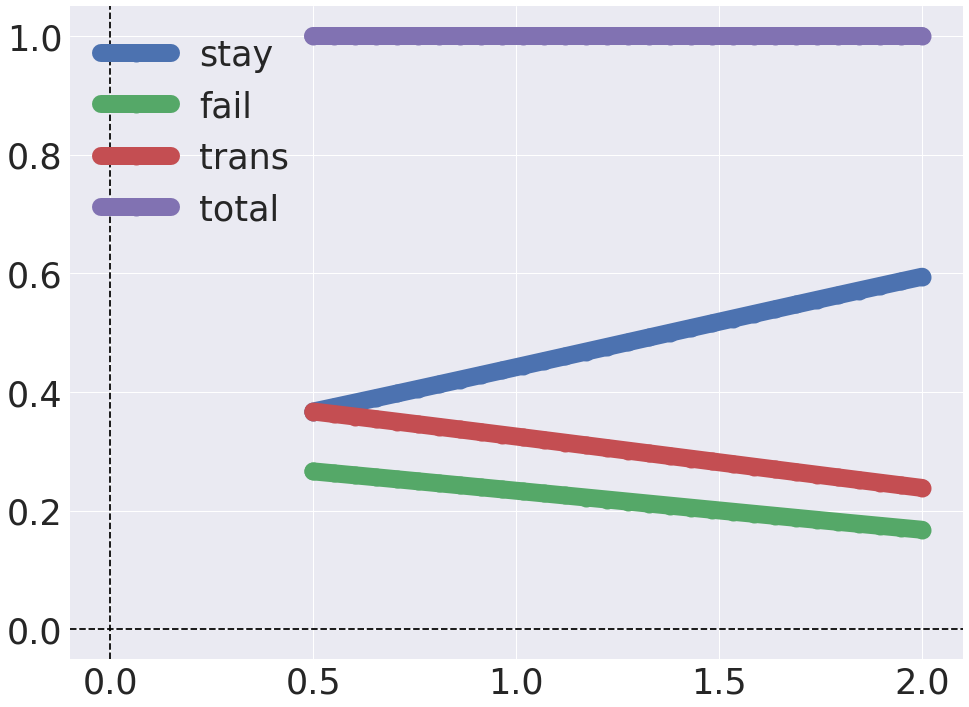

In [190]:
%%time
sigma = 2.0
w1 = 2.0
w2 = 0.5
w3 = 0.0

num = 30
w1_vector = np.linspace(2.0, w2, num=num)
p1_vector = np.zeros(num)
p2_vector = np.zeros(num)
p3_vector = np.zeros(num)

for index, w1, in enumerate(w1_vector):

    p1_vector[index] = stay_at_t(w1, w2, w3, sigma)
    p2_vector[index] = fail_at_t(w1, w2, w3, sigma)
    p3_vector[index] = transtition_at_t(w1, w2, w3, sigma)

lw = 18
ms = 18
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(w1_vector, p1_vector, 'o-', lw=lw, ms=ms, label='stay')
ax.plot(w1_vector, p2_vector, 'o-', lw=lw, ms=ms, label='fail')
ax.plot(w1_vector, p3_vector, 'o-', lw=lw, ms=ms, label='trans')
ax.plot(w1_vector, p1_vector + p2_vector + p3_vector, 'o-', lw=lw, ms=ms, label='total')


ax.axhline(0, ls='--', color='black')
ax.axvline(0, ls='--', color='black');
ax.legend();

Let's try to plot remain probability

In [199]:
dt = 0.0001
Ttotal = 0.150
time = np.arange(0, Ttotal, dt)
n_t  = time.size
tau_a = 0.150
tau_m = 0.010
w_self = 1.0
w_next = 0.5
w_rest = 0.4
w_diff = w_self - w_next
w_rob = w_self - w_rest
g_w = 1.0
g_a = 1.0
base_sigma = 1.5
perfect = False
steady_state = True


perfect = False
steady_state = True
T_per = calculate_T_persistence(tau_a, g_w, w_diff, g_a, tau_m, perfect=perfect)
mu = mean_at_t(time, w_self, w_next, g_a, tau_m, tau_a, s0=w_next, perfect=perfect, steady_state=steady_state)

In [200]:
p_stay = np.zeros_like(mu)
p_fail = np.zeros_like(mu)
p_transition = np.zeros_like(mu)
for index, w1 in enumerate(mu):
    sigma = np.sqrt(tau_m) * base_sigma / np.sqrt(2)
    p_stay[index] = stay_at_t(w1, w_next, w_rest, sigma)
    p_fail[index] = fail_at_t(w1, w_next, w_rest, sigma)
    p_transition[index] = transtition_at_t(w1, w_next, w_rest, sigma)

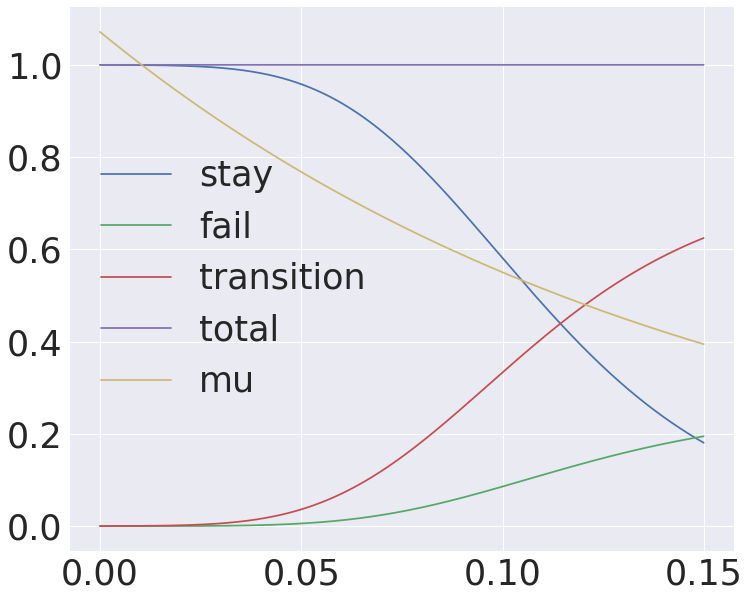

In [201]:
plt.plot(time, p_stay, label='stay')
plt.plot(time, p_fail, label='fail')
plt.plot(time, p_transition, label='transition')
plt.plot(time, p_stay + p_fail +  p_transition, label='total')
plt.plot(time, mu, label='mu')

plt.legend()

#### Accross sigma

In [187]:
dt = 0.0001
Ttotal = 0.150
time = np.arange(0, Ttotal, dt)
n_t  = time.size
tau_a = 0.150
tau_m = 0.010
w_self = 1.0
w_next = 0.5
w_rest = 0.0
w_diff = w_self - w_next
w_rob = w_self - w_rest
g_w = 1.0
g_a = 1.0
base_sigma = 1.0
perfect = False
steady_state = True

num = 50
sigma_vector = np.linspace(0.1, 2.5, num=num)
p_stay = np.zeros_like(sigma_vector)
p_fail = np.zeros_like(sigma_vector)
p_transition = np.zeros_like(sigma_vector)

w1 = 0.65

for index, base_sigma in enumerate(sigma_vector):
    sigma = np.sqrt(tau_m) * base_sigma / np.sqrt(2)
    p_stay[index] = stay_at_t(w1, w_next, w_rest, sigma)
    p_fail[index] = fail_at_t(w1, w_next, w_rest, sigma)
    p_transition[index] = transtition_at_t(w1, w_next, w_rest, sigma)

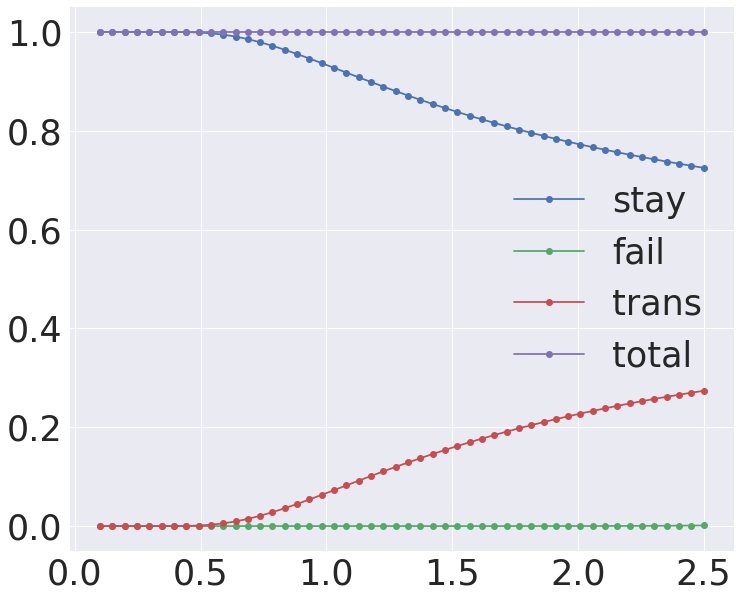

In [188]:
plt.plot(sigma_vector, p_stay, 'o-', label='stay')
plt.plot(sigma_vector, p_fail, 'o-', label='fail')
plt.plot(sigma_vector, p_transition, 'o-', label='trans')
plt.plot(sigma_vector, p_transition + p_fail + p_stay, 'o-', label='total')


plt.legend()